In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.fftpack import  fft, ifft, ifftshift
from scipy.signal import correlate
from sklearn.metrics import r2_score
import sys

sys.path.append('..')

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

# Arguments + Parameters

In [3]:
data_processing_args_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/data_processing_args"

# Batch Queue

In [4]:
mp_args = dict(
    # ----------------------
    # MULTIPROCESSING ARGUMENTS
    # ----------------------
    USE_TORCH=True,
    USE_CUDA=False,
    DTYPE='torch.DoubleTensor',
    NUM_WORKERS=20,
#     NUM_WORKERS=4,
    USE_LOGGING=True,
    LOG_DIR="/om2/user/eisenaj/code/shell_scripts/DeLASE",
    LOG_NAME='mp_delase',
    LOG_LEVEL=logging.DEBUG,
    RESULTS_DIR='/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/performance_results_VAR',
    
    COMPUTE_IP=True,
    COMPUTE_CHROOTS=False,
    SAVE_JACOBIANS=False,
    TRACK_RESEEDS=True,
    NORM = False,
    NORM_AIC=True,
    
    QUEUE_FULL_SESSION=True,

    # ----------------------
    # DYNAMICAL SYSTEMS ARGUMENTS
    # ----------------------
    parameter_grid=ParameterGrid(
                        window_vals=np.array([15000]),
                        matrix_size_vals=np.array([750]),
                        r_vals=np.array([750]),
                        reseed=True,
                        reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
                    ),
    T_pred=15000, # time steps
    dt = 0.001, # s
    integrated_performance_kwargs = dict(
        metrics=['autocorrel_correl', 'fft_correl', 'fft_r2'], 
        weights='equal',
        num_lags=500,
        max_freq=200,
        fft_n=1000,
    ),
#     integrated_performance_kwargs = {},
    stability_max_freq = 500,
    stability_max_unstable_freq = 125,
    
)
mp_args = argparse.Namespace(**mp_args)

In [5]:
# session_list = [
#     'MrJones-Anesthesia-20160113-01',
#     'Mary-Anesthesia-20160809-01',
#     'MrJones-Anesthesia-20160105-01',
#     'Mary-Anesthesia-20160818-02',
#     'MrJones-Anesthesia-20160121-01',
#     'Mary-Anesthesia-20160831-02',
#     'MrJones-Anesthesia-20160123-01'
# ]

# session_list = [
#     'Mary-Anesthesia-20160902-02',
#     'Mary-Anesthesia-20160908-02',
#     'Mary-Anesthesia-20160914-02',
#     'Mary-Anesthesia-20160916-02',

#     'MrJones-Anesthesia-20160125-01',
#     'MrJones-Anesthesia-20160201-01',
#     'MrJones-Anesthesia-20160206-01',
#     'MrJones-Anesthesia-20160210-01',
#     'MrJones-Anesthesia-20160301-01'
# ]

session_list = os.listdir("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results")

In [6]:
session_list = session_list[:2]
# session_list = session_list[4:]

# Other

In [7]:
# device = 'cuda'
# norm_folder = "NOT_NORMED" if not mp_args.NORM else "NORMED"
# for session in tqdm(session_list):
#     print("-"*30)
#     print(f'SESSION = {session}')
#     print("-"*30)
#     # -----------------------------------------
#     # LOAD DATA AND DIRECTORY
#     # -----------------------------------------
#     print("loading data...")
#     all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
#     data_class = get_data_class(session, all_data_dir)

#     os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
#     # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
#     # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
#     # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

#     variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
#     session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
#     electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

#     eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
#     section_times = dict( 
#             pre=(0, session_info['drugStart'][0]),
#             induction=(session_info['drugStart'][0], eyes_close),
#             during=(eyes_close, session_info['drugEnd'][1]),
#             post=(session_info['drugEnd'][1], T*dt)
#     )
#     sections = list(section_times.keys())
# #     areas = np.unique(electrode_info['area'])
#     # areas = np.hstack([areas, 'all'])
#     areas = ['all']
    
#     print("data loaded!")
#     print("loading directory")
    
#     chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
#     if len(chunked_folder) == 0:
#         print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
#     else:
#         chunked_folder = chunked_folder[0]

#     directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))
    
#     print("directory loaded!")
    
#     # -----------------------------------------
#     # LOAD GRID SEARCH RESULTS
#     # -----------------------------------------
    
#     session_results = {}
#     session_results[session] = {}
#     # data_processing_df_grid = deepcopy(mp_args.data_processing_df)

#     grid_results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'
#     areas = os.listdir(os.path.join(grid_results_dir, session, norm_folder))

#     for area in areas:
#         df = pd.DataFrame({'window': [], 'matrix_size': [], 'r': [], 'AICs': [], 'time_vals': [], 'file_paths': []}).set_index(['window', 'matrix_size', 'r'])
#         for f in os.listdir(os.path.join(grid_results_dir, session, norm_folder, area)):
#             t = float(f.split('_')[0])
#             file_path = os.path.join(grid_results_dir, session, norm_folder, area, f)
#             df_new = pd.DataFrame(pd.read_pickle(file_path))
#             if np.isnan(df_new.AIC).sum() > 0:
#                 print(file_path)
#             df_new = df_new.set_index(['window', 'matrix_size', 'r'])
#             for i, row in df_new.iterrows():
#                 if i in df.index:
#                     df.loc[i, 'AICs'].append(row.AIC)
#                     df.loc[i, 'time_vals'].append(t)
#                     df.loc[i, 'file_paths'].append(file_path)
#                 else:
#                     df.loc[i] = {'AICs': [row.AIC], 'time_vals': [t], 'file_paths': [file_path]}

#         df = df.loc[df.index.sortlevel()[0]]
#         session_results[session][area] = df
    
#     print("Grid search results loaded!")

#     # ================
#     # INDIVIDUAL AREAS
#     # ================ 
#     window, matrix_size, r, all_results = combine_grid_results({key: result for key, result in session_results[session].items() if key !='all'})

#     # ================
#     # ALL AREAS
#     # ================ 
#     if 'all' in session_results[session].keys():
#         window_all, matrix_size_all, r_all, all_results_all = combine_grid_results({key: result for key, result in session_results[session].items() if key =='all'})

#     # ================
#     # QUEUE A JOB FOR EACH AREA
#     # ================ 
#     for area in areas:
# #     for area in ['all']:
#         print("-"*20)
#         print(f"AREA = {area}")
#         print("-"*20)
#         data_processing_rows = []
#         if area != 'all':
#             stride = window
#             mp_args.parameter_grid = ParameterGrid(
#                 window_vals = np.array([window]),
#                 matrix_size_vals = np.array([matrix_size]),
#                 r_vals = np.array([r]),
#                 reseed=mp_args.parameter_grid.reseed,
#                 reseed_vals=mp_args.parameter_grid.reseed_vals,
#             )
#         else:
#             stride = window_all
#             mp_args.parameter_grid = ParameterGrid(
#                 window_vals = np.array([window_all]),
#                 matrix_size_vals = np.array([matrix_size_all]),
#                 r_vals = np.array([r_all]),
#                 reseed=mp_args.parameter_grid.reseed,
#                 reseed_vals=mp_args.parameter_grid.reseed_vals,
#             )
#         results_dir = os.path.join(mp_args.RESULTS_DIR, os.path.join(session, 'NORMED' if mp_args.NORM else 'NOT_NORMED', area))
#         os.makedirs(results_dir, exist_ok=True)
#         if area == 'all':
#             unit_indices = np.arange(len(electrode_info['area']))
#         else:
#             unit_indices = np.where(electrode_info['area'] == area)[0]

#         num_windows = int(len(lfp_schema['index'][0])/window)
#         for num_window in tqdm(range(num_windows)):
#             t = window*num_window
#             finished = True
#             file_path = os.path.join(results_dir, f"{t*dt:.1f}_window_{window}_VAR")
#             if not os.path.exists(file_path):
#                 row = dict(
#                     session=session,
#                     area=area,
#                     window_start=t*mp_args.dt,
#                     window_end=(t + window + mp_args.T_pred)*mp_args.dt,
#                     window=window,
#                     r=None,
#                     matrix_size=None,
#                 )
                
#                 signal = load_window_from_chunks(row['window_start'], row['window_end'], directory, unit_indices)
#                 A = torch.from_numpy(np.linalg.lstsq(signal[:window-1], signal[1:window], rcond=1e-13)[0].T).to(device)
#                 signal_test = torch.from_numpy(signal[window:window + mp_args.T_pred]).to(device)
#                 all_metric_vals = []
# #                 for reseed in tqdm(mp_args.parameter_grid.reseed_vals):
#                 for reseed in [1]:
#                     preds = torch.zeros(signal_test.shape).type('torch.DoubleTensor').to(device)
#                     preds[0] = signal_test[0]
#                     for t_ in range(1, signal_test.shape[0]):
#                         if t_ % reseed == 0:
#                             preds[t_] = A @ signal_test[t_ - 1]
#                         else:
#                             preds[t_] = A @ preds[t_ - 1]
                    
# #                     all_metric_vals.append(signal_metrics(signal_test, preds, metrics=['autocorrel_correl', 'fft_correl', 'fft_r2'], use_torch=True, device=device))
                    
#                     if reseed == 1:
#                         N = (signal_test.shape[0] - 1)*signal_test.shape[1]
#                         row['AIC'] = float(N*torch.log(((preds[1:] - signal_test[1:])**2).sum()/N) + 2*(A.shape[0]*A.shape[1] + 1))/N
#                         row['mse_1step'] = float(((preds[1:] - signal_test[1:])**2).mean().cpu().numpy())
#                 # HAVOK
#                 delase = DeLASE(signal[:window], matrix_size=matrix_size, use_torch=True, device=device)
#                 delase.compute_havok_dmd(r =r)
#                 preds2 = delase.predict_havok_dmd(signal_test)
#                 row['AIC_havok'] = float(N*torch.log(((preds2[1:] - signal_test[1:])**2).sum()/N) + 2*(delase.A_v.shape[0]*delase.A_v.shape[1] + 1))/N
#                 row['mse_1step_havok'] = float(((preds2[1:] - signal_test[1:])**2).mean().cpu().numpy())
                
#                 row['AIC_pb'] = float(N*torch.log(((signal_test[:-1] - signal_test[1:])**2).sum()/N))/N
#                 row['mse_1step_pb'] = float(((signal_test[:-1] - signal_test[1:])**2).mean().cpu().numpy())
                
#                 # WINDOW 500 VAR
#                 signal = load_window_from_chunks(row['window_start'], row['window_end'], directory, unit_indices)
#                 A = torch.from_numpy(np.linalg.lstsq(signal[:500-1], signal[1:500], rcond=1e-13)[0].T).to(device)
#                 signal_test = torch.from_numpy(signal[500:500 + 500]).to(device)
#                 preds = (A @ signal_test.T).T
#                 N = (signal_test.shape[0] - 1)*signal_test.shape[1]
#                 row['AIC_500'] = float(N*torch.log(((preds[1:] - signal_test[1:])**2).sum()/N) + 2*(A.shape[0]*A.shape[1] + 1))/N
#                 row['mse_1step_500'] = float(((preds[1:] - signal_test[1:])**2).mean().cpu().numpy())
                
# #                 row['all_metric_vals'] = all_metric_vals
# #                 row['Js'] = (A.cpu().numpy() - dt)/np.eye(A.shape[0])
                
#                 pd.to_pickle([row], file_path)
        
#         data_processing_df = pd.DataFrame(data_processing_rows)
   

In [8]:
rets = {}
for session in os.listdir(mp_args.RESULTS_DIR):
    rets[session] = {}
    for area in os.listdir(os.path.join(mp_args.RESULTS_DIR, session, "NOT_NORMED")):
        rets[session][area] = None
        area_dir = os.path.join(mp_args.RESULTS_DIR, session, "NOT_NORMED", area)
        for f in tqdm(os.listdir(area_dir)):
            ret = pd.DataFrame(pd.read_pickle(os.path.join(area_dir, f)))
            if rets[session][area] is None:
                rets[session][area] = ret
            else:
                rets[session][area] = pd.concat([rets[session][area], ret])

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/442 [00:00<?, ?it/s]

  0%|          | 0/442 [00:00<?, ?it/s]

  0%|          | 0/442 [00:00<?, ?it/s]

  0%|          | 0/442 [00:00<?, ?it/s]

  0%|          | 0/442 [00:00<?, ?it/s]

In [9]:
session_list

['Mary-Anesthesia-20160908-02', 'MrJones-Anesthesia-20160301-01']

In [10]:
areas = ['vlPFC', 'FEF', '7b', 'CPB', 'all']

In [11]:
# fig, axs = plt.subplots(2, 5, figsize=(15, 5))
# for i, session in enumerate(session_list):
#     for j, area in enumerate(areas):
#         ax = axs[i][j]
#         mean_vals = [rets[session][area].AIC_pb.mean(), rets[session][area].AIC_500.mean(), rets[session][area].AIC.mean(), rets[session][area].AIC_havok.mean()]
#         se_vals = [rets[session][area].AIC_pb.std()/np.sqrt(len(rets[session][area])), rets[session][area].AIC_500.std()/np.sqrt(len(rets[session][area])), rets[session][area].AIC.std()/np.sqrt(len(rets[session][area])), rets[session][area].AIC_havok.std()/np.sqrt(len(rets[session][area]))]
#         ax.bar(['PB', 'VAR\n(small)', 'VAR\n(full)', 'HAVOK'], -np.array(mean_vals), yerr=se_vals)
#         ax.set_yscale('log')
# plt.tight_layout()
# plt.show()

In [12]:
# fig, axs = plt.subplots(5, 2, figsize=(10, 10))
# for i, session in enumerate(session_list):
#     for j, area in enumerate(areas):
#         ax = axs[j][i]
#         mean_vals = [rets[session][area].mse_1step_pb.mean(), rets[session][area].mse_1step_500.mean(), rets[session][area].mse_1step.mean(), rets[session][area].mse_1step_havok.mean()]
#         se_vals = [rets[session][area].mse_1step_pb.std()/np.sqrt(len(rets[session][area])), rets[session][area].mse_1step_500.std()/np.sqrt(len(rets[session][area])), rets[session][area].mse_1step.std()/np.sqrt(len(rets[session][area])), rets[session][area].mse_1step_havok.std()/np.sqrt(len(rets[session][area]))]
#         ax.bar(['PB', 'VAR\n(small)', 'VAR\n(full)', 'HAVOK'], np.array(mean_vals), yerr=se_vals)
#         ax.set_yscale('log')
#         if j == 0:
#             ax.set_title(area)
#         if i == 0:
#             ax.set_ylabel(session.split('-')[0])
# plt.tight_layout()
# plt.show()

In [29]:
def barplot_annotate_brackets(num1, num2, p, center, height, it=0, ax=None, ylim=None, scale_by_height=False, yerr=None, dh=.05, barh=.05, gap=None, fs=None, maxasterix=None, below=False):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """
    
    data = gen_data(p)
    
    if ax is None:
        ax = plt.gca()
    
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'
#     print(np.log10(height))

    if gap is None:
        gap = dh

    lx, ly = center[num1], height[num1]
    if below:
        ly = np.min(height)
    else:
        ly = np.max(height)
    rx, ry = center[num2], height[num2]
    if below:
        ry = np.min(height)
    else:
        ry = np.max(height)

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    if scale_by_height:
        ax_y0, ax_y1 = np.min(np.array(height) + np.array(yerr)), np.max(np.array(height) + np.array(yerr))
    else:
        if ylim is None:
            ax_y0, ax_y1 = ax.get_ylim()
        else:
            ax_y0, ax_y1 = ylim
    dh *= (ax_y1 - ax_y0)
    gap *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)
#     barh *= (np.max(height) - np.min(height))
    
    if ax.get_yscale() == 'log':
        mult = np.power(4, it/2)
    else:
        mult = 1
    
    if below:
        y = min(ly, ry) - dh - mult*it*gap
    else:
        y = max(ly, ry) + dh + mult*it*gap
    
   

    barx = [lx, lx, rx, rx]
    if below:
        bary = [y, y-barh, y-barh, y]
        mid = ((lx+rx)/2, y-barh)
    else:
        bary = [y, y+barh, y+barh, y]
        mid = ((lx+rx)/2, y+barh)

    ax.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.text(*mid, text, **kwargs)

def gen_data(p):
    if p == 0 or p < 1e-15:
        data = 'p < 1e-15'
    elif p <= 0.05 and p >= 1e-4:
        data = p
    else:
        data = f"p < 1e-{int(-np.log10(p))}"
    
    return data

In [30]:
model_colors = ['#BBBBBB', 'teal', 'darkturquoise', 'coral']

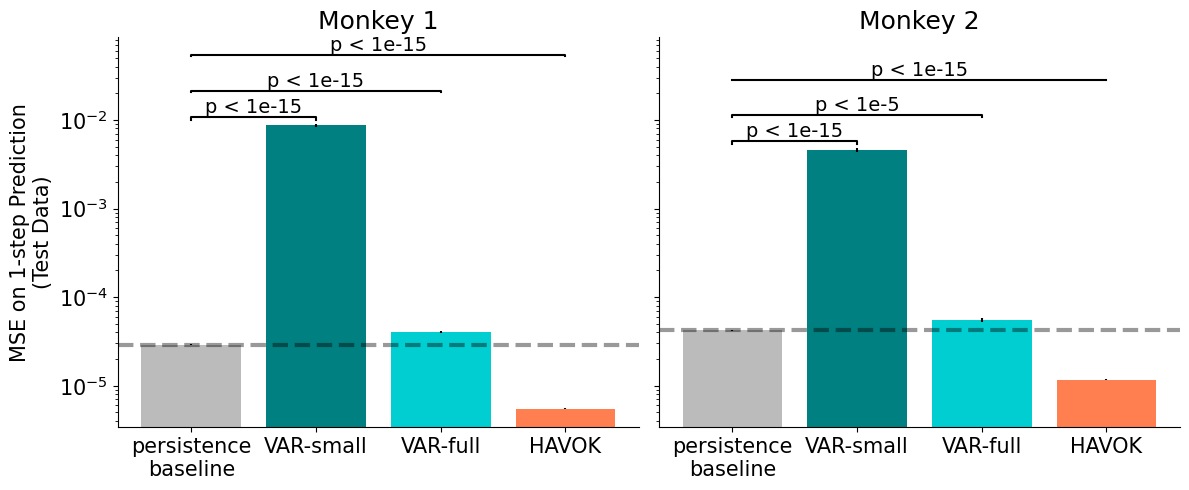

In [39]:
tick_fontsize = 15
title_fontsize = 18
ylabel_fontsize = 15
p_fontsize=14

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for i, session in enumerate(session_list):
    for j, area in enumerate(['all']):
        ax = axs[i]
        mean_vals = [rets[session][area].mse_1step_pb.mean(), rets[session][area].mse_1step_500.mean(), rets[session][area].mse_1step.mean(), rets[session][area].mse_1step_havok.mean()]
        se_vals = [rets[session][area].mse_1step_pb.std()/np.sqrt(len(rets[session][area])), rets[session][area].mse_1step_500.std()/np.sqrt(len(rets[session][area])), rets[session][area].mse_1step.std()/np.sqrt(len(rets[session][area])), rets[session][area].mse_1step_havok.std()/np.sqrt(len(rets[session][area]))]
        bar_labels = ['persistence\nbaseline', 'VAR-small', 'VAR-full', 'HAVOK']
        bars = [0, 1, 2, 3]
        heights = np.array(mean_vals)
        ax.bar(bars, heights, yerr=se_vals, color=model_colors)
        ax.set_xticks(bars)
        ax.set_xticklabels(bar_labels)
        ax.set_yscale('log')
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        
        if j == 0:
            ax.set_title(f"Monkey {i + 1}", fontsize=title_fontsize)
            
        if i == 0:
            ax.set_ylabel(f"MSE on 1-step Prediction\n(Test Data)", fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    
        ax = axs[i]
        dh = 0.1
        gap = 0.6
        barh = 0.1
        p = scipy.stats.ttest_ind(rets[session][area].mse_1step_pb, rets[session][area].mse_1step_500, alternative='less').pvalue
        barplot_annotate_brackets(0, 1, p, bars, heights, yerr=se_vals, scale_by_height=True, ax=ax, it=0, dh=dh, barh=barh, gap=gap, fs=p_fontsize)
        p = scipy.stats.ttest_ind(rets[session][area].mse_1step_pb, rets[session][area].mse_1step, alternative='less').pvalue
        barplot_annotate_brackets(0, 2, p, bars, heights, yerr=se_vals, scale_by_height=True, ax=ax, it=1, dh=dh, barh=barh, gap=gap, fs=p_fontsize)
        p = scipy.stats.ttest_ind(rets[session][area].mse_1step_pb, rets[session][area].mse_1step_havok, alternative='greater').pvalue
        barplot_annotate_brackets(0, 3, p, bars, heights, yerr=se_vals, scale_by_height=True, ax=ax, it=2, dh=dh, barh=barh, gap=gap, fs=p_fontsize)
        
        ax.axhline(rets[session][area].mse_1step_pb.mean(), linestyle='--', c='k', linewidth=3, alpha=0.4)
        
plt.tight_layout()
plt.show()

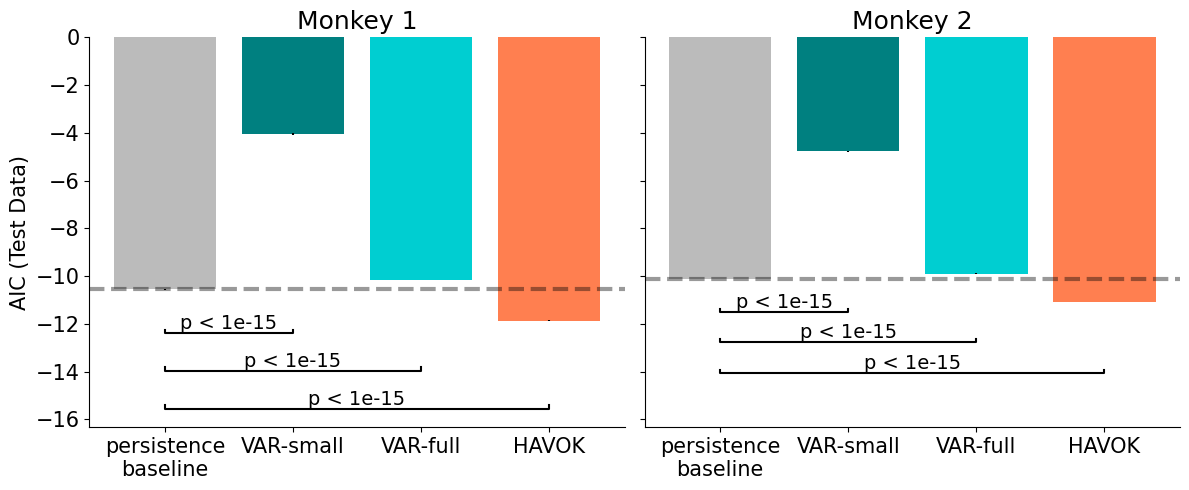

In [40]:
tick_fontsize = 15
title_fontsize = 18
ylabel_fontsize = 15
p_fontsize=14

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for i, session in enumerate(session_list):
    for j, area in enumerate(['all']):
        ax = axs[i]
        mean_vals = [rets[session][area].AIC_pb.mean(), rets[session][area].AIC_500.mean(), rets[session][area].AIC.mean(), rets[session][area].AIC_havok.mean()]
        se_vals = [rets[session][area].AIC_pb.std()/np.sqrt(len(rets[session][area])), rets[session][area].AIC_500.std()/np.sqrt(len(rets[session][area])), rets[session][area].AIC.std()/np.sqrt(len(rets[session][area])), rets[session][area].AIC_havok.std()/np.sqrt(len(rets[session][area]))]
        bar_labels = ['persistence\nbaseline', 'VAR-small', 'VAR-full', 'HAVOK']
        bars = [0, 1, 2, 3]
        heights = np.array(mean_vals)
        ax.bar(bars, heights, yerr=se_vals, color=model_colors)
        ax.set_xticks(bars)
        ax.set_xticklabels(bar_labels)
#         ax.set_yscale('log')
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        
        if j == 0:
            ax.set_title(f"Monkey {i + 1}", fontsize=title_fontsize)
            
        if i == 0:
            ax.set_ylabel(f"AIC (Test Data)", fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    
        ax = axs[i]
        dh = 0.05
        gap = 0.2
        barh = 0.02
        p = scipy.stats.ttest_ind(rets[session][area].AIC_pb, rets[session][area].AIC_500, alternative='less').pvalue
        barplot_annotate_brackets(0, 1, p, bars, heights, yerr=se_vals, scale_by_height=True, ax=ax, it=0, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=True)
        p = scipy.stats.ttest_ind(rets[session][area].AIC_pb, rets[session][area].AIC, alternative='less').pvalue
        barplot_annotate_brackets(0, 2, p, bars, heights, yerr=se_vals, scale_by_height=True, ax=ax, it=1, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=True)
        p = scipy.stats.ttest_ind(rets[session][area].AIC_pb, rets[session][area].AIC_havok, alternative='greater').pvalue
        barplot_annotate_brackets(0, 3, p, bars, heights, yerr=se_vals, scale_by_height=True, ax=ax, it=2, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=True)
        
        ax.axhline(rets[session][area].AIC_pb.mean(), linestyle='--', c='k', linewidth=3, alpha=0.4)
        
plt.tight_layout()
plt.show()

# Curves

In [17]:
f = f"/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/performance_results/Mary-Anesthesia-20160908-02/NOT_NORMED/vlPFC/0.0_window_15000_matrix_size_750"

In [18]:
f = pd.read_pickle(f)

In [19]:
# SESSION = 'Mary-Anesthesia-20160908-02'

In [20]:
session = 'MrJones-Anesthesia-20160301-01'

In [21]:
# -----------------------------------------
# LOAD DATA AND DIRECTORY
# -----------------------------------------
print("loading data...")
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
#     areas = np.unique(electrode_info['area'])
# areas = np.hstack([areas, 'all'])
areas = ['all']

print("data loaded!")
print("loading directory")

chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

print("directory loaded!")


loading data...
data loaded!
loading directory
directory loaded!


In [22]:
area = 'all'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [23]:
norm_folder = "NOT_NORMED"

In [24]:
# -----------------------------------------
# LOAD GRID SEARCH RESULTS
# -----------------------------------------

session_results = {}
session_results[session] = {}
# data_processing_df_grid = deepcopy(mp_args.data_processing_df)

grid_results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'
areas = os.listdir(os.path.join(grid_results_dir, session, norm_folder))

for area in areas:
    df = pd.DataFrame({'window': [], 'matrix_size': [], 'r': [], 'AICs': [], 'time_vals': [], 'file_paths': []}).set_index(['window', 'matrix_size', 'r'])
    for f in os.listdir(os.path.join(grid_results_dir, session, norm_folder, area)):
        t = float(f.split('_')[0])
        file_path = os.path.join(grid_results_dir, session, norm_folder, area, f)
        df_new = pd.DataFrame(pd.read_pickle(file_path))
        if np.isnan(df_new.AIC).sum() > 0:
            print(file_path)
        df_new = df_new.set_index(['window', 'matrix_size', 'r'])
        for i, row in df_new.iterrows():
            if i in df.index:
                df.loc[i, 'AICs'].append(row.AIC)
                df.loc[i, 'time_vals'].append(t)
                df.loc[i, 'file_paths'].append(file_path)
            else:
                df.loc[i] = {'AICs': [row.AIC], 'time_vals': [t], 'file_paths': [file_path]}

    df = df.loc[df.index.sortlevel()[0]]
    session_results[session][area] = df

print("Grid search results loaded!")

# ================
# INDIVIDUAL AREAS
# ================ 
window_ind, matrix_size_ind, r_ind, all_results_ind = combine_grid_results({key: result for key, result in session_results[session].items() if key !='all'})

# ================
# ALL AREAS
# ================ 
if 'all' in session_results[session].keys():
    window_all, matrix_size_all, r_all, all_results_all = combine_grid_results({key: result for key, result in session_results[session].items() if key =='all'})

Grid search results loaded!


In [25]:
if area == 'all':
    window, matrix_size, r = window_all, matrix_size_all, r_all
else:
    window, matrix_size, r = window_ind, matrix_size_ind, r_ind

# Old

In [345]:
stride = 60000*6

In [346]:
num_windows = int(len(lfp_schema['index'][0])/stride)

In [664]:
num_lags=500

In [718]:
all_rets = []
# metrics = ['correl', 'mse', 'autocorrel_mse', 'autocorrel_correl', 'fft_correl', 'div', 'correl_mat_correl', 'correl_mat_mse']

reseeds=[10, 50, 5000]

metric_kwargs = dict(
    metrics=['autocorrel_correl', 'fft_correl', 'log_fft_correl', 'correl_mat_correl', 'div'],
#     metrics=['fft_correl', 'log_fft_correl'],
    num_lags=num_lags,
    dt=dt,
    min_freq=min_freq,
    max_freq=200,
    spectrum_smoothing_width=0.5,
    standardize=True,
    verbose=False,
    use_torch=True,
    return_components=True
)

# for i in tqdm(range(num_windows)):
#     t = i*stride
time_vals = [int(500/dt), int((session_info['drugStart'][1] - 30)/dt)]
# reseeds = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

iterator = tqdm(total=len(time_vals)*len(reseeds)*5)
for t in time_vals:
    
    signal_train = load_window_from_chunks(t*dt, t*dt + window*dt, directory, unit_indices)
    
#     print("fitting delase big!")
#     delase_big = DeLASE(signal_train, matrix_size=8000, use_torch=True, device='cuda')
#     delase_big.compute_havok_dmd(r=7000)
#     print("completed delase big!")

    print("fitting delase small!")
    delase_small = DeLASE(signal_train, matrix_size=matrix_size, use_torch=True, device='cuda')
    delase_small.compute_havok_dmd(r=r)
    print("completed delase small!")

    print("fitting VAR small!")
    small_window = 500
    A_VAR_small = np.linalg.lstsq(signal_train[:small_window-1], signal_train[1:small_window], rcond=1e-20)[0].T
    print("completed VAR small!")

    print("fitting VAR big!")
    A_VAR = np.linalg.lstsq(signal_train[:-1], signal_train[1:], rcond=1e-20)[0].T
    print("completed VAR big!")

    all_metric_vals = []
    all_metric_vals_big = []
    all_metric_vals_VAR = []
    all_metric_vals_VAR_small = []
    all_metric_vals_pb = []
    # reseeds = mp_args.parameter_grid.reseed_vals
   
    for reseed in reseeds:
#         metric_kwargs['num_lags'] = np.min([num_lags, int(reseed/2)])
    #     signal_test = signal[:reseed]
#         signal_test = load_window_from_chunks(t*dt + window*dt, t*dt + 2*window*dt, directory, unit_indices)
        signal_test = load_window_from_chunks(t*dt + window*dt, t*dt + window*dt + 5000*dt, directory, unit_indices)
#         signal_test = load_window_from_chunks(t*dt + window*dt, t*dt + window*dt + reseed*dt, directory, unit_indices)
        
        
        pred = np.zeros(signal_test.shape)
        pred[0] = signal_test[0]
        for t_ in range(1, signal_test.shape[0]):
            if t_ % reseed == 0:
                pred[t_] = signal_test[t_ - 1]
            else:
                pred[t_] = pred[t_ - 1]
        all_metric_vals_pb.append(signal_metrics(signal_test, pred, **metric_kwargs))
        iterator.update()

        pred = delase_small.predict_havok_dmd(signal_test, reseed=reseed, tail_bite=True)
        all_metric_vals.append(signal_metrics(signal_test, pred, **metric_kwargs))
        
        iterator.update()
        
#         pred = delase_big.predict_havok_dmd(signal_test, reseed=reseed, tail_bite=True)
#         all_metric_vals_big.append(signal_metrics(signal_test, pred, **metric_kwargs))
        
        iterator.update()

        pred = np.zeros(signal_test.shape)
        pred[0] = signal_test[0]
        for t_ in range(1, signal_test.shape[0]):
            if t_ % reseed == 0:
                pred[t_] = A_VAR @ signal_test[t_ - 1]
            else:
                pred[t_] = A_VAR @ pred[t_ - 1]
        all_metric_vals_VAR.append(signal_metrics(signal_test, pred, **metric_kwargs))
        
        iterator.update()
        
        pred = np.zeros(signal_test.shape)
        pred[0] = signal_test[0]
        for t_ in range(1, signal_test.shape[0]):
            if t_ % reseed == 0:
                pred[t_] = A_VAR_small @ signal_test[t_ - 1]
            else:
                pred[t_] = A_VAR_small @ pred[t_ - 1]
        all_metric_vals_VAR_small.append(signal_metrics(signal_test, pred, **metric_kwargs))
    #     print("VAR done")
        
        iterator.update()
    
    all_rets.append(dict(
        all_metric_vals = all_metric_vals,
#         all_metric_vals_big = all_metric_vals_big,
        all_metric_vals_VAR = all_metric_vals_VAR,
        all_metric_vals_VAR_small = all_metric_vals_VAR_small,
        all_metric_vals_pb=all_metric_vals_pb,
    ))
iterator.close()

  0%|          | 0/30 [00:00<?, ?it/s]

fitting delase small!
completed delase small!
fitting VAR small!
completed VAR small!
fitting VAR big!
completed VAR big!


In [719]:
pd.to_pickle(all_rets, "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp/all_metric_rets")

In [720]:
combined_rets = {}
counts = {}
keys = list(all_rets[0].keys())

In [721]:
for model in keys:
    combined_rets[model] = {}
    counts[model] = {}
    for metric in metric_kwargs['metrics']:
        combined_rets[model][metric] = None
        counts[model][metric] = 0
        for ret in all_rets:
            curve = [float(d[0][metric].cpu()) if torch.is_tensor(d[0][metric]) else d[0][metric] for d in ret[model]]
            if combined_rets[model][metric] is None:
                combined_rets[model][metric] = np.array(curve)
            else:
                combined_rets[model][metric] += np.array(curve)
            counts[model][metric] += 1
        combined_rets[model][metric] /= counts[model][metric]

In [722]:
combined_rets

{'all_metric_vals': {'autocorrel_correl': array([0.98064653, 0.90265401, 0.75543408]),
  'fft_correl': array([0.9733473 , 0.93842751, 0.89870145]),
  'log_fft_correl': array([0.90270054, 0.89653926, 0.93122086]),
  'correl_mat_correl': array([0.98242751, 0.93295724, 0.64660171]),
  'div': array([      -inf,       -inf, 0.20327016])},
 'all_metric_vals_VAR': {'autocorrel_correl': array([0.98611635, 0.90107092, 0.77401081]),
  'fft_correl': array([0.98246035, 0.93862663, 0.90324732]),
  'log_fft_correl': array([0.91138148, 0.90116635, 0.95160906]),
  'correl_mat_correl': array([0.97748864, 0.88337689, 0.61018648]),
  'div': array([0.01645887,       -inf, 0.14775018])},
 'all_metric_vals_VAR_small': {'autocorrel_correl': array([0.44056222, 0.34523093, 0.00652956]),
  'fft_correl': array([0.55667157, 0.46061624, 0.76990513]),
  'log_fft_correl': array([0.45176345, 0.58598447, 0.95762238]),
  'correl_mat_correl': array([0.56617009, 0.71881718, 0.27540703]),
  'div': array([-inf, -inf, -inf]

In [768]:
reseeds[reseed_ind]

5000

In [846]:
signal_ind = 1
reseed_ind = 1
metric = 'correl_mat'

In [847]:
a = all_rets[signal_ind]['all_metric_vals'][reseed_ind][1][metric]['true']
b = all_rets[signal_ind]['all_metric_vals'][reseed_ind][1][metric]['pred']
correls_havok = np.zeros(a.shape[0])
for i in range(a.shape[0]):
    correls_havok[i] = scipy.stats.spearmanr(a[i], b[i]).correlation

a = all_rets[signal_ind]['all_metric_vals_VAR'][reseed_ind][1][metric]['true']
b = all_rets[signal_ind]['all_metric_vals_VAR'][reseed_ind][1][metric]['pred']
correls_VAR = np.zeros(a.shape[0])
for i in range(a.shape[0]):
    correls_VAR[i] = scipy.stats.spearmanr(a[i], b[i]).correlation
    
a = all_rets[signal_ind]['all_metric_vals_VAR_small'][reseed_ind][1][metric]['true']
b = all_rets[signal_ind]['all_metric_vals_VAR_small'][reseed_ind][1][metric]['pred']
correls_VAR_small = np.zeros(a.shape[0])
for i in range(a.shape[0]):
    correls_VAR_small[i] = scipy.stats.spearmanr(a[i], b[i]).correlation

a = all_rets[signal_ind]['all_metric_vals_pb'][reseed_ind][1][metric]['true']
b = all_rets[signal_ind]['all_metric_vals_pb'][reseed_ind][1][metric]['pred']
correls_pb = np.zeros(a.shape[0])
for i in range(a.shape[0]):
    correls_pb[i] = scipy.stats.spearmanr(a[i], b[i]).correlation

In [848]:
scipy.stats.ttest_ind(correls_havok, correls_VAR, alternative='greater')

Ttest_indResult(statistic=2.0871807326185974, pvalue=0.018690843150892564)

In [849]:
scipy.stats.ttest_ind(correls_havok, correls_pb, alternative='greater')

Ttest_indResult(statistic=-13.274977423910721, pvalue=1.0)

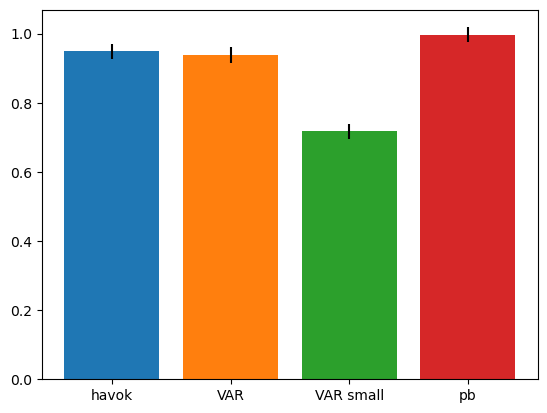

In [850]:
plt.bar('havok', correls_havok.mean(), yerr=correls.std()/np.sqrt(len(correls_havok)))
plt.bar('VAR', correls_VAR.mean(), yerr=correls.std()/np.sqrt(len(correls_VAR)))
plt.bar('VAR small', correls_VAR_small.mean(), yerr=correls.std()/np.sqrt(len(correls_VAR)))
plt.bar('pb', correls_pb.mean(), yerr=correls.std()/np.sqrt(len(correls_VAR)))
plt.show()

0.9525700502802009

In [745]:
a.shape

torch.Size([249, 500])

In [737]:
.shape

torch.Size([249, 500])

In [734]:
signal_ind = 0
reseed_ind = -1
all_rets[signal_ind]['all_metric_vals'][reseed_ind][1]['autocorrel']['true']

tensor([[ 1.0000e+00,  9.7696e-01,  9.2062e-01,  ..., -4.1139e-02,
         -4.1464e-02, -4.1705e-02],
        [ 1.0000e+00,  9.7699e-01,  9.2275e-01,  ..., -2.7775e-02,
         -2.7959e-02, -2.6667e-02],
        [ 1.0000e+00,  9.8210e-01,  9.3834e-01,  ..., -3.5691e-02,
         -3.6109e-02, -3.6206e-02],
        ...,
        [ 1.0000e+00,  9.9446e-01,  9.7921e-01,  ...,  2.8784e-01,
          2.8960e-01,  2.9106e-01],
        [ 1.0000e+00,  9.9195e-01,  9.6958e-01,  ...,  1.7802e-04,
          4.1653e-03,  7.7576e-03],
        [ 1.0000e+00,  9.9176e-01,  9.6874e-01,  ...,  1.2603e-02,
          1.8559e-02,  2.4074e-02]], dtype=torch.float64)

In [723]:
scipy.stats.spearmanr

<function scipy.stats.stats.spearmanr(a, b=None, axis=0, nan_policy='propagate', alternative='two-sided')>

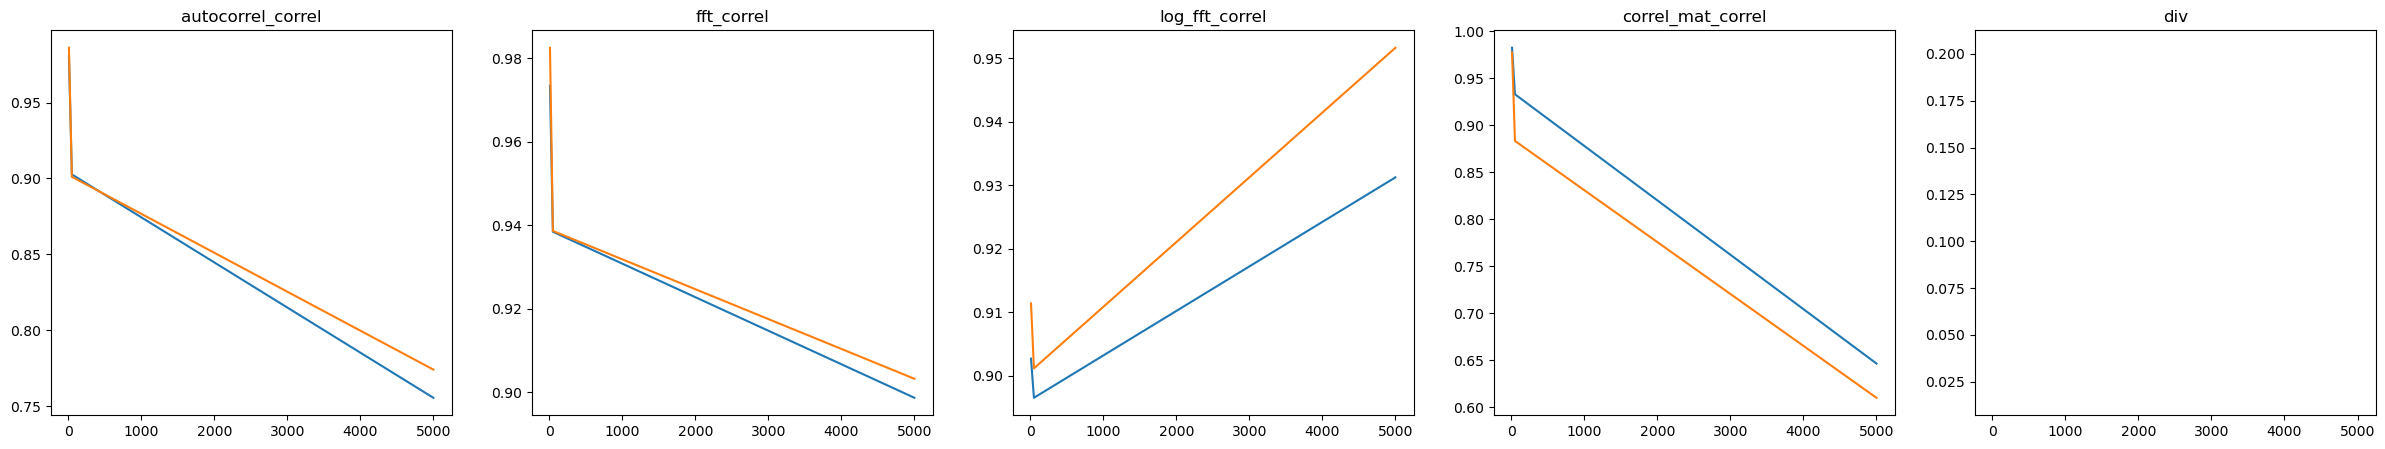

In [725]:
fig, axs = plt.subplots(1, len(metric_kwargs['metrics']), figsize = (30, 5))

for i, metric in enumerate(metric_kwargs['metrics']):
    if len(metric_kwargs['metrics']) == 1:
        ax = axs
    else:
        ax = axs[i]
 
    ax.plot(reseeds, combined_rets['all_metric_vals'][metric])
    ax.plot(reseeds, combined_rets['all_metric_vals_VAR'][metric])
#     ax.plot(reseeds, combined_rets['all_metric_vals_VAR_small'][metric])
#     ax.plot(reseeds, combined_rets['all_metric_vals_big'][metric])
#     ax.plot(reseeds, combined_rets['all_metric_vals_pb'][metric])
    
#     ax.bar(0, combined_rets['all_metric_vals'][metric])
#     ax.bar(1, combined_rets['all_metric_vals_VAR'][metric])
#     ax.bar(2, combined_rets['all_metric_vals_VAR_small'][metric])
# #     ax.plot(reseeds, combined_rets['all_metric_vals_big'][metric])
#     ax.bar(3, combined_rets['all_metric_vals_pb'][metric])
    
#     ax.plot(reseeds, combined_rets['all_metric_vals_VAR_small'][metric])
    ax.set_title(metric)

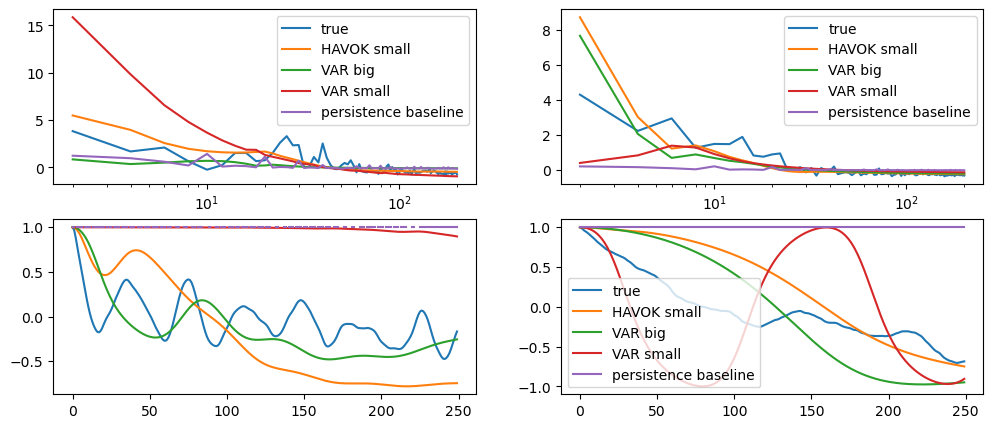

In [709]:
fig, axs = plt.subplots(2, 2, figsize=(12, 5))
for ind, model in enumerate(all_rets[0].keys()):
    if len(all_rets[0][model]) > 0:
        wake_ret = all_rets[0][model][0][1]
        anesthesia_ret = all_rets[1][model][0][1]

        for i, data in enumerate([wake_ret, anesthesia_ret]):

            ax = axs[0][i]
            if ind == 0:
                ax.plot(data['fft']['freqs'], data['fft']['true'][0], label='true')
            
            skip = False
            if model == 'all_metric_vals':
                label = 'HAVOK small'
            elif model == 'all_metric_vals_big':
                label = 'HAVOK big'
            elif model == 'all_metric_vals_VAR':
                label = 'VAR big'
            elif model == 'all_metric_vals_VAR_small':
                label = 'VAR small'
                skip = False
            elif model == 'all_metric_vals_pb':
                label = 'persistence baseline'
                skip = False
            if not skip:
                ax.plot(data['fft']['freqs'], data['fft']['pred'][0], label=label)
            ax.set_xscale('log')
            ax.legend()
            
            ax = axs[1][i]
            if ind == 0:
                ax.plot(data['autocorrel']['true'][0], label='true')
            if not skip:
                ax.plot(data['autocorrel']['pred'][0], label=label)
plt.legend()
plt.show()

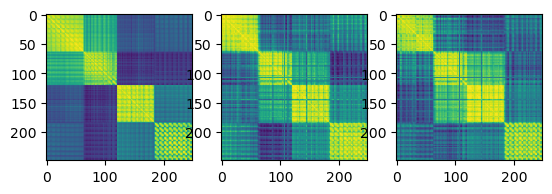

In [540]:
model = 'all_metric_vals'
data = all_rets[0][model][1][1]

correl_mat = data['correl_mat']['true'].cpu().numpy().copy()
correl_mat[np.arange(correl_mat.shape[0]), np.arange(correl_mat.shape[1])] = 1
plt.subplot(1, 3, 1)
plt.imshow(correl_mat)

plt.subplot(1, 3, 2)
correl_mat = data['correl_mat']['pred'].cpu().numpy().copy()
correl_mat[np.arange(correl_mat.shape[0]), np.arange(correl_mat.shape[1])] = 1
plt.imshow(correl_mat)


model = 'all_metric_vals_VAR'
data = all_rets[0][model][1][1]

plt.subplot(1, 3, 3)
correl_mat = data['correl_mat']['pred'].cpu().numpy().copy()
correl_mat[np.arange(correl_mat.shape[0]), np.arange(correl_mat.shape[1])] = 1
plt.imshow(correl_mat)

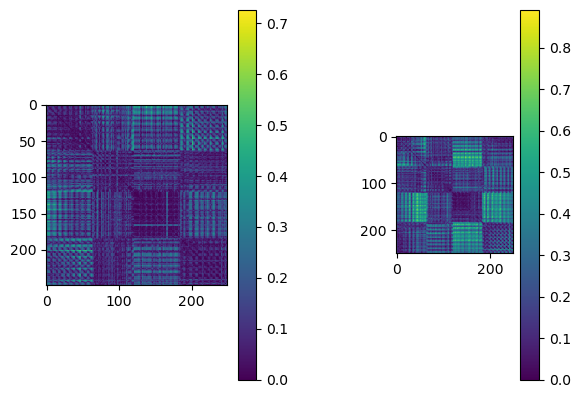

In [851]:
model = 'all_metric_vals'
data = all_rets[0][model][1][1]

correl_mat_true = data['correl_mat']['true'].cpu().numpy().copy()
correl_mat_true[np.arange(correl_mat.shape[0]), np.arange(correl_mat.shape[1])] = 1

plt.subplot(1, 2, 1)
correl_mat = data['correl_mat']['pred'].cpu().numpy().copy()
correl_mat[np.arange(correl_mat.shape[0]), np.arange(correl_mat.shape[1])] = 1
plt.imshow(np.abs(correl_mat - correl_mat_true))
plt.colorbar()


model = 'all_metric_vals_VAR_small'
data = all_rets[0][model][1][1]

plt.subplot(1, 3, 3)
correl_mat = data['correl_mat']['pred'].cpu().numpy().copy()
correl_mat[np.arange(correl_mat.shape[0]), np.arange(correl_mat.shape[1])] = 1
plt.imshow(np.abs(correl_mat - correl_mat_true))
plt.colorbar()

# New

In [26]:
def get_fft(x, dt=1, min_freq=0, max_freq=500, spectrum_smoothing_width=0, log=False, standardize=False):
    fft = np.zeros((x.shape[1], int(x.shape[0]/2) + 1))
    for i in range(x.shape[1]):
        stdev = x[:, i].std()
        if standardize and stdev != 0:
            inp = (x[:, i] - x[:,i].mean())/stdev
        else:
            inp = x[:, i]
        fft[i] = np.abs(np.fft.rfft(inp))
    freqs = np.fft.rfftfreq(x.shape[0], d=dt)
    
    freq_inds = np.logical_and(freqs >= min_freq, freqs <= max_freq)
    fft = fft[:, freq_inds]
    freqs = freqs[freq_inds]
    
    df = freqs[0]
    if spectrum_smoothing_width > 0:
        for i in range(fft.shape[0]):
            fft[i] = scipy.ndimage.gaussian_filter1d(fft[i], spectrum_smoothing_width/df)
    
    if log:
        fft = 10*np.log10(fft)
    
    if standardize:
        for i in range(fft.shape[0]):
            fft[i] = (fft[i] - fft[i].mean())/fft.std()
    
    return fft

In [27]:
fft_kwargs = dict(
    dt=dt,
    min_freq=0.2,
    max_freq=100,
    spectrum_smoothing_width=0.5,
    log=False,
    standardize=False
)

In [28]:
def autocorrelation(x):
    ac = np.zeros((x.shape[1], int(x.shape[0]/2)))
    for i in range(ac.shape[0]):
        stdev = np.std(x[:,i])
        if stdev == 0:
            inp = x[:, i]
        else:
            inp = (x[:,i] - np.average(x[:,i]))/stdev
        xp = ifftshift(inp)
        n, = xp.shape
        xp = np.r_[xp[:n//2], np.zeros_like(xp), xp[n//2:]]
        f = fft(xp)
        p = np.absolute(f)**2
        pi = ifft(p)
        ac[i] = np.real(pi)[:n//2]/(np.arange(n//2)[::-1]+n//2)
    return ac

In [29]:
def correlation_matrices(x, num_lags=0, lag_spacing=1):
    corrmats = np.zeros((num_lags + 1, x.shape[1], x.shape[1]))
    corrmats[0] = np.corrcoef(x.T)
    for lag in range(1, num_lags + 1):
        out = np.corrcoef(x[:-lag*lag_spacing, :].T, x[lag*lag_spacing:, :].T)
        corrmats[lag] = out[:x.shape[1], x.shape[1]:]
    
    return corrmats

In [30]:
stride = 240000
# num_windows = int(len(lfp_schema['index'][0])/stride)
num_windows = int((session_info['drugEnd'][1]/dt + stride)/stride)
# time_vals = [i*stride for i in range(num_windows)]

In [31]:
all_rets = []
# metrics = ['correl', 'mse', 'autocorrel_mse', 'autocorrel_correl', 'fft_correl', 'div', 'correl_mat_correl', 'correl_mat_mse']

num_lags=5000
num_cmat_lags = 25
lag_spacing = 10
# reseeds=[500]
reseeds = [1, 2, 3, 5, 7, 10]

# for i in tqdm(range(num_windows)):
#     t = i*stride
time_vals = [int(500/dt), int((session_info['drugStart'][1] - 30)/dt)]
# reseeds = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp/all_reseed_results"
os.makedirs(save_dir, exist_ok=True)

iterator = tqdm(total=len(time_vals)*len(reseeds)*5)
for t in time_vals:
    results = {}
    
    signal_train = load_window_from_chunks(t*dt, t*dt + window*dt, directory, unit_indices)
    
#     print("fitting delase big!")
#     delase_big = DeLASE(signal_train, matrix_size=6500, use_torch=True, device='cuda')
#     delase_big.compute_havok_dmd(r=6000)
#     print("completed delase big!")

    print("fitting delase small!")
    delase_small = DeLASE(signal_train, matrix_size=matrix_size, use_torch=True, device='cuda')
    delase_small.compute_havok_dmd(r=r)
    print("completed delase small!")

    print("fitting VAR small!")
    small_window = 500
    A_VAR_small = np.linalg.lstsq(signal_train[:small_window-1], signal_train[1:small_window], rcond=1e-20)[0].T
    print("completed VAR small!")

    print("fitting VAR big!")
    A_VAR = np.linalg.lstsq(signal_train[:-1], signal_train[1:], rcond=1e-20)[0].T
    print("completed VAR big!")
   
    for reseed in reseeds:
        results[reseed] = {}
#         metric_kwargs['num_lags'] = np.min([num_lags, int(reseed/2)])
    #     signal_test = signal[:reseed]
#         signal_test = load_window_from_chunks(t*dt + window*dt, t*dt + 2*window*dt, directory, unit_indices)
        signal_test = load_window_from_chunks(t*dt + window*dt, t*dt + window*dt + 5000*dt, directory, unit_indices)
#         signal_test = load_window_from_chunks(t*dt + window*dt, t*dt + window*dt + reseed*dt, directory, unit_indices)
        
        results[reseed]['true'] = {}
        results[reseed]['true']['signal'] = signal_test
        results[reseed]['true']['autocorrel'] = autocorrelation(signal_test)[:, :num_lags]
        results[reseed]['true']['fft'] = get_fft(signal_test, **fft_kwargs)
        results[reseed]['true']['correl_mats'] = correlation_matrices(signal_test, num_cmat_lags, lag_spacing)
        
        pred = np.zeros(signal_test.shape)
        pred[0] = signal_test[0]
        for t_ in range(1, signal_test.shape[0]):
            if t_ % reseed == 0:
                pred[t_] = signal_test[t_ - 1]
            else:
                pred[t_] = pred[t_ - 1]
        results[reseed]['PB'] = {}
        results[reseed]['PB']['signal'] = pred
        results[reseed]['PB']['autocorrel'] = autocorrelation(pred)[:, :num_lags]
        results[reseed]['PB']['fft'] = get_fft(pred, **fft_kwargs)
        results[reseed]['PB']['correl_mats'] = correlation_matrices(pred, num_cmat_lags, lag_spacing)
#         all_metric_vals_pb.append(signal_metrics(signal_test, pred, **metric_kwargs))
        iterator.update()

        pred = delase_small.predict_havok_dmd(signal_test, reseed=reseed, tail_bite=True).cpu().numpy()
        results[reseed]['havok'] = {}
        results[reseed]['havok']['signal'] = pred
        results[reseed]['havok']['autocorrel'] = autocorrelation(pred)[:, :num_lags]
        results[reseed]['havok']['fft'] = get_fft(pred, **fft_kwargs)
        results[reseed]['havok']['correl_mats'] = correlation_matrices(pred, num_cmat_lags, lag_spacing)
        
        iterator.update()
        
#         pred = delase_big.predict_havok_dmd(signal_test, reseed=reseed, tail_bite=True).cpu().numpy()
#         results[reseed]['havok_big'] = {}
#         results[reseed]['havok_big']['signal'] = pred
#         results[reseed]['havok_big']['autocorrel'] = autocorrelation(pred)[:, :num_lags]
#         results[reseed]['havok_big']['fft'] = get_fft(pred, **fft_kwargs)
#         results[reseed]['havok_big']['correl_mats'] = correlation_matrices(pred, num_cmat_lags, lag_spacing)
        
#         iterator.update()

        pred = np.zeros(signal_test.shape)
        pred[0] = signal_test[0]
        for t_ in range(1, signal_test.shape[0]):
            if t_ % reseed == 0:
                pred[t_] = A_VAR @ signal_test[t_ - 1]
            else:
                pred[t_] = A_VAR @ pred[t_ - 1]
#         all_metric_vals_VAR.append(signal_metrics(signVARal_test, pred, **metric_kwargs))
        results[reseed]['VAR'] = {}
        results[reseed]['VAR']['signal'] = pred
        results[reseed]['VAR']['autocorrel'] = autocorrelation(pred)[:, :num_lags]
        results[reseed]['VAR']['fft'] = get_fft(pred, **fft_kwargs)
        results[reseed]['VAR']['correl_mats'] = correlation_matrices(pred, num_cmat_lags, lag_spacing)
        
        iterator.update()
        
        pred = np.zeros(signal_test.shape)
        pred[0] = signal_test[0]
        for t_ in range(1, signal_test.shape[0]):
            if t_ % reseed == 0:
                pred[t_] = A_VAR_small @ signal_test[t_ - 1]
            else:
                pred[t_] = A_VAR_small @ pred[t_ - 1]
#         all_metric_vals_VAR_small.append(signal_metrics(signal_test, pred, **metric_kwargs))
        results[reseed]['VAR_small'] = {}
        results[reseed]['havok']['VAR_small'] = pred
        results[reseed]['VAR_small']['autocorrel'] = autocorrelation(pred)[:, :num_lags]
        results[reseed]['VAR_small']['fft'] = get_fft(pred, **fft_kwargs)
        results[reseed]['VAR_small']['correl_mats'] = correlation_matrices(pred, num_cmat_lags, lag_spacing)
    #     print("VAR done")
        
        
        iterator.update()
#     pd.to_pickle(results, os.path.join(save_dir, f"{t*dt:.1f}_pred_rets"))
    
iterator.close()

  0%|          | 0/60 [00:00<?, ?it/s]

fitting delase small!
completed delase small!
fitting VAR small!
completed VAR small!
fitting VAR big!
completed VAR big!
fitting delase small!
completed delase small!
fitting VAR small!
completed VAR small!
fitting VAR big!
completed VAR big!


In [1361]:
correlation_matrices(pred, num_cmat_lags).shape

(26, 249, 249)

In [1362]:
times = list(results.keys())
reseeds = list(results[times[0]].keys())
models = list(results[times[0]][reseeds[0]].keys())
metrics = list(results[times[0]][reseeds[0]][models[0]].keys())

In [1363]:
iterator = tqdm(total=len(times)*len(reseeds)*len(models)*len(metrics))
correls = {}
for t in times:
    correls[t] = {}
    for reseed in reseeds:
        correls[t][reseed] = {}
        for model in models:
            if model != 'true':
                correls[t][reseed][model] = {}
                for metric in metrics:
                    correl_vec = np.zeros(results[t][reseed][model][metric].shape[0])
                    for i in range(correl_vec.shape[0]):
                        a = results[t][reseed][model][metric][i]
                        b = results[t][reseed]['true'][metric][i]
#                         correl_vec[i] = scipy.stats.spearmanr(a, b).correlation
#                         if metric == 'correl_mats':
#                             correl_vec[i] = np.corrcoef(a.flatten(), b.flatten())[0, 1]
#                             correl_vec[i] = r2_score(a.flatten(), b.flatten())
#                         else:
#                             correl_vec[i] = np.corrcoef(a, b)[0, 1]
#                             correl_vec[i] = r2_score(a, b)
                        correl_vec[i] = ((a - b)**2).mean()
                
                    correls[t][reseed][model][metric] = correl_vec
                    iterator.update()
            else:
                iterator.update(len(metrics))
        
iterator.close()

  0%|          | 0/36 [00:00<?, ?it/s]

KeyError: 500

In [1364]:
t = times[0]

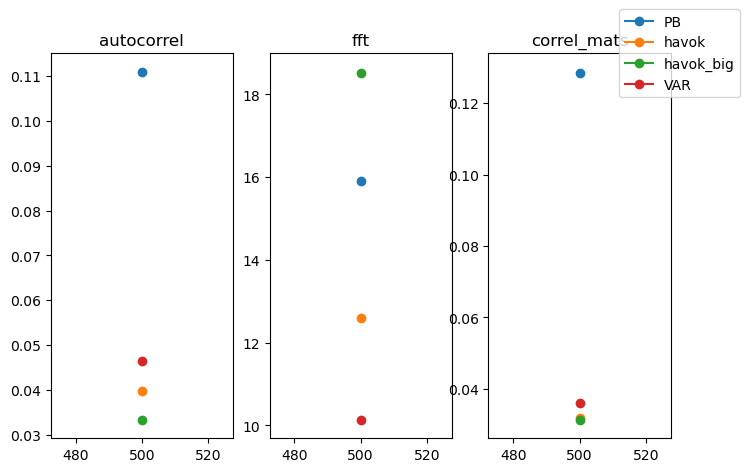

In [1365]:
fig, axs = plt.subplots(1, len(metrics), figsize=(8, 5))
for i, metric in enumerate(metrics):
    if len(metrics) == 1:
        ax = axs
    else:
        ax = axs[i]
    for model in models:
        if model != 'true' and model != 'VAR_small':
            mean_vals = np.array([correls[t][reseed][model][metric].mean() for reseed in correls[t].keys()])
            se_vals = np.array([correls[t][reseed][model][metric].std()/len(correls[t][reseed][model][metric]) for reseed in correls[t].keys()])

            ax.plot(reseeds, mean_vals, marker='o', label=model)
            ax.fill_between(reseeds, mean_vals - se_vals, mean_vals + se_vals, alpha=0.4)
            ax.set_title(metric)
            # plt.plot(mean_vals, markers='o')

ax.legend(bbox_to_anchor=(1.05, 1), loc='center')
plt.show()

In [1366]:
reseed = reseeds[-1]

In [1370]:
t = times[0]

In [1371]:
metric = 'fft'

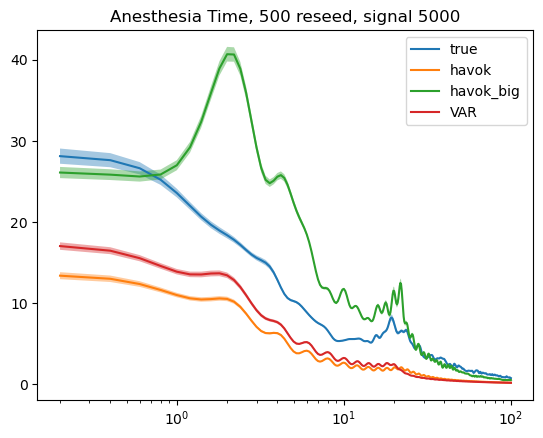

In [1372]:
freqs = np.fft.rfftfreq(signal_test.shape[0], dt)
freq_inds = np.logical_and(freqs >= fft_kwargs['min_freq'], freqs <= fft_kwargs['max_freq'])
for model in models:
    if model not in ['PB', 'VAR_small']:
        means = results[t][reseed][model][metric].mean(axis=0)
        se = results[t][reseed][model][metric].std(axis=0)/np.sqrt(results[t][reseed][model][metric].shape[0])
        plt.plot(freqs[freq_inds], means, label=model)
        plt.fill_between(freqs[freq_inds], means - se, means + se, alpha=0.4)
        
# plt.title('Anesthesia Time, 500 reseed, signal 5000')

plt.legend()
plt.xscale('log')

In [1348]:
metric = 'autocorrel'
t = times[1]

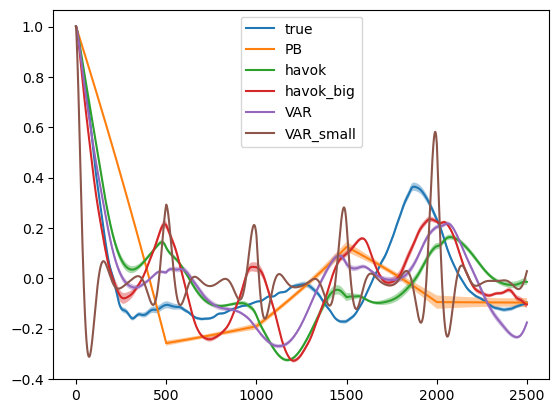

In [1349]:
freqs = np.fft.rfftfreq(signal_test.shape[0], dt)
freq_inds = np.logical_and(freqs >= fft_kwargs['min_freq'], freqs <= fft_kwargs['max_freq'])
for model in models:
    means = results[t][reseed][model][metric].mean(axis=0)
    se = results[t][reseed][model][metric].std(axis=0)/np.sqrt(results[t][reseed][model][metric].shape[0])
    plt.plot(means, label=model)
    plt.fill_between(np.arange(len(means)), means - se, means + se, alpha=0.4)

plt.legend()